In [29]:
import pandas as pd
import numpy as np

# Reading the data
df = pd.read_csv('/home/test/workspace/research_project_ws23/final/00_latest_may/new_straight_no_noise.csv')

# Extracting and transposing data
GT = {
    'x': df['GT_x'].values,
    'y': df['GT_y'].values,
    'alpha': df['GT_alpha'].values,
    'Kr': df['GT_Kr'].values,
    'v': df['GT_v'].values
}

t = df['time'].values
Ts = t[1] - t[0]

# Adding noise to alpha
aa = GT['alpha'] + np.sqrt(1e-2) * np.random.randn(len(t))

# Extracting position data
y = np.array([df['Pos_x'].values, df['Pos_y'].values])


In [30]:
import numpy as np

# Define constants
R0 = 1
Q0 = 11

# Compute lambda
lambda_ = Ts * np.sqrt(Q0 / R0)

# Calculate K1 and K2
K1 = -1/8 * (lambda_**2 + 8*lambda_ - (lambda_ + 4) * np.sqrt(lambda_**2 + 8*lambda_))
K2 = 0.25 * (lambda_**2 + 4*lambda_ - lambda_ * np.sqrt(lambda_**2 + 8*lambda_)) / Ts

# Create K0 and H matrices
K0 = np.array([K1, K2])
H = np.array([[1 - K1, Ts - K1 * Ts],
              [-K2, 1 - K2 * Ts]])


In [31]:
import numpy as np

# ROSE FILTER

# Constants and parameters
# Gamma = 0.9          # Factor for measurement noise
Alpha_R = 0.08       # Smoothing factor measurement noise
Alpha_M = 0.1

# EKF Initialization
R = np.cov(y[:, :100])

qxy = 2E-5
qa = 4E-4
qKr = 3E-4
qv = 5E-3

# Process noise covariance matrix
GQG = np.array([
    [qxy, 0, 0, 0, 0],
    [0, qxy, 0, 0, 0],
    [0, 0, qa, 0, 0],
    [0, 0, 0, qKr, 0],
    [0, 0, 0, 0, qv]
], dtype=np.float64)

# Measurement matrix
Cj = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0]
],dtype=np.float64)

# Initial estimates
x_dach = np.array([y[0, 0], y[1, 0], 0, 0, 0], dtype=np.float64)
P_dach = np.diag([0.1, 0.1, 1e-2, 1e-3, 1e-2])

x1 = np.array([y[0, 0], 0], dtype=np.float64)
x2 = np.array([y[1, 0], 0], dtype=np.float64)

M = Cj @ P_dach @ Cj.T + R


In [32]:
import numpy as np
import math

# Assuming y, H, K0, Cj, x_dach, P_dach, Ts, Gamma, Alpha_R, GQG are already defined

# Initialization of arrays for storing results
# xR = np.zeros(y.shape[1])
# yR = np.zeros(y.shape[1])
# r1 = np.zeros(y.shape[1])
# r2 = np.zeros(y.shape[1])
# xP = np.zeros(y.shape[1])
# yP = np.zeros(y.shape[1])
# alpha = np.zeros(y.shape[1])
# Kr = np.zeros(y.shape[1])
# v = np.zeros(y.shape[1])

xR, yR, r1, r2, xP, yP, alpha, Kr, v, m1, m2, m3 = ([] for i in range(12))

# Regularization term
epsilon = 1e-1  # Further increased regularization


for k in range(len(y.T)):
    x1 = H @ x1 + K0 * y[0, k]
    xR.append(x1[0])
    x2 = H @ x2 + K0 * y[1, k]
    yR.append(x2[0])

    # R = Gamma * Alpha_R * np.outer(y[:, k] - np.array([x1[0], x2[0]]), y[:, k] - np.array([x1[0], x2[0]])) + (1 - Alpha_R) * R
    
    y_diff = y[:, k] - np.array([x1[0], x2[0]])
    # R_update = np.outer(y_diff, y_diff)
    # R = Gamma * Alpha_R * R_update + (1 - Alpha_R) * R
    r1.append(R[0, 0])
    r2.append(R[1, 1])


    dy = y[:, k]
    
    # # M update
    # M_diff = dy - Cj @ x_dach
    M_update = np.outer(dy, dy)
    M = Alpha_M * M_update + (1 - Alpha_M) * M

    # Regularize M to avoid singularity
    M += np.eye(M.shape[0]) * epsilon

    # Append the diagonal elements of M to the lists
    m1.append(M[0, 0])
    m2.append(M[1, 1])
    # Append the third element of M to the list
    m3.append(M[1, 0])


    invM = np.linalg.inv(M)
    K = P_dach @ Cj.T @ invM
    x_tilde = x_dach + K @ dy

    # Debug statements to check the state update
    print(f"Iteration {k}: K = {K}")
    print(f"Iteration {k}: dy = {dy}")
    print(f"Iteration {k}: x_tilde = {x_tilde}")

    P_tilde = (np.eye(len(x_dach)) - K @ Cj) @ P_dach @ (np.eye(len(x_dach)) - K @ Cj).T + K @ R @ K.T * epsilon

    xP.append(x_tilde[0])
    yP.append(x_tilde[1])
    alpha.append(x_tilde[2])
    Kr.append(x_tilde[3])
    v.append(x_tilde[4])

    # print(f"Iteration {k}: xP = {xP[-1]}, yP = {yP[-1]}, alpha = {alpha[-1]}")
    print(f"Iteration {k}: xP = {xP[-1]}, yP = {yP[-1]}, alpha = {alpha[-1]}, Kr = {Kr[-1]}, v = {v[-1]}")
    if np.isnan(xP[-1]) or np.isinf(xP[-1]):
        print(f"NaN or Inf detected at iteration {k}")

    # if k == 18:
    #     print("Debug Breakpoint")

    x_dach = np.array([
        xP[k] - v[k] * Ts * math.sin(alpha[k]),
        yP[k] + v[k] * Ts * math.cos(alpha[k]),
        alpha[k] + v[k] * Ts * Kr[k],
        Kr[k],
        v[k]
    ])

    Aj = np.array([
        [1, 0, -v[k] * Ts * math.cos(alpha[k]), 0, -Ts * math.sin(alpha[k])],
        [0, 1, -v[k] * Ts * math.sin(alpha[k]), 0, Ts * math.cos(alpha[k])],
        [0, 0, 1, v[k] * Ts, Kr[k] * Ts],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])

    P_dach = Aj @ (P_tilde + GQG) @ Aj.T

    # Additional debug statements
    print(f"Iteration {k}: x_dach = {x_dach}")
    print(f"Iteration {k}: P_dach = {P_dach}")

# Outputs are stored df xR, yR, r1, r2, xP, yP, alpha, Kr, v
    
    time = df['time'].values
    Pos_x = df['Pos_x'].values
    Pos_y = df['Pos_y'].values
    GT_x = df['GT_x'].values
    GT_y = df['GT_y'].values
    GT_alpha = df['GT_alpha'].values
    GT_Kr = df['GT_Kr'].values
    GT_v = df['GT_v'].values
    ROSE_x = xP
    ROSE_y = yP
    ROSE_alpha = alpha
    ROSE_Kr = Kr
    ROSE_v = v

M

Iteration 0: K = [[0.52631579 0.        ]
 [0.         0.0128783 ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
Iteration 0: dy = [0. 0.]
Iteration 0: x_tilde = [0. 0. 0. 0. 0.]
Iteration 0: xP = 0.0, yP = 0.0, alpha = 0.0, Kr = 0.0, v = 0.0
Iteration 0: x_dach = [0. 0. 0. 0. 0.]
Iteration 0: P_dach = [[0.02245767 0.         0.         0.         0.        ]
 [0.         0.09775052 0.         0.         0.0015    ]
 [0.         0.         0.0104     0.         0.        ]
 [0.         0.         0.         0.0013     0.        ]
 [0.         0.0015     0.         0.         0.015     ]]
Iteration 1: K = [[0.08286964 0.        ]
 [0.         0.01378807]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.00021158]]
Iteration 1: dy = [0.  0.1]
Iteration 1: x_tilde = [0.00000000e+00 1.37880691e-03 0.00000000e+00 0.00000000e+00
 2.11580506e-05]
Iteration 1: xP = 0.0, yP = 0.0013788069113563057, alpha = 0.0, Kr = 0.0, v = 2.115805063826795e-05
Ite

array([[ 0.99997609,  0.        ],
       [ 0.        , 82.90014919]])

In [33]:
import pandas as pd
import numpy as np

# EKF Initialization
qxy = 2E-5
qa = 4E-4
qKr = 3E-4
qv = 5E-3
GQG = np.array([
    [qxy, 0, 0, 0, 0],
    [0, qxy, 0, 0, 0],
    [0, 0, qa, 0, 0],
    [0, 0, 0, qKr, 0],
    [0, 0, 0, 0, qv]
])

R = np.cov(y[:, :100])

# Initial state estimate
x_dach = np.array([y[0, 0], y[1, 0], 0, 0, 0])

# Initial covariance estimate
P_dach = np.diag([0.1, 0.1, 1e-2, 1e-3, 1e-2])


In [34]:
import numpy as np
import math

# Initialize arrays to store the results
length_y = y.shape[1]
xP = np.zeros(length_y)
yP = np.zeros(length_y)
alpha = np.zeros(length_y)
Kr = np.zeros(length_y)
v = np.zeros(length_y)

# Initial state estimate
x_dach = np.array([y[0, 0], y[1, 0], 0, 0, 0])  # Modify as per your initial condition

for k in range(length_y):
    dy = y[:, k] - Cj @ x_dach
    M = Cj @ P_dach @ Cj.T + R
    invM = np.linalg.inv(M)
    K = P_dach @ Cj.T @ invM
    x_tilde = x_dach + K @ dy
    P_tilde = (np.eye(len(x_dach)) - K @ Cj) @ P_dach @ (np.eye(len(x_dach)) - K @ Cj).T + K @ R @ K.T

    xP[k] = x_tilde[0]
    yP[k] = x_tilde[1]
    alpha[k] = x_tilde[2]
    Kr[k] = x_tilde[3]
    v[k] = x_tilde[4]

    x_dach = np.array([
        xP[k] - v[k] * Ts * math.sin(alpha[k]),
        yP[k] + v[k] * Ts * math.cos(alpha[k]),
        alpha[k] + v[k] * Ts * Kr[k],
        Kr[k],
        v[k]
    ])

    Aj = np.array([
        [1, 0, -v[k] * Ts * math.cos(alpha[k]), 0, -Ts * math.sin(alpha[k])],
        [0, 1, -v[k] * Ts * math.sin(alpha[k]), 0, Ts * math.cos(alpha[k])],
        [0, 0, 1, v[k] * Ts, Kr[k] * Ts],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])

    P_dach = Aj @ (P_tilde + GQG) @ Aj.T

# Transpose not needed in Python as the results are already in the correct format
EKF_x = xP
EKF_y = yP
EKF_alpha = alpha
EKF_Kr = Kr
EKF_v = v


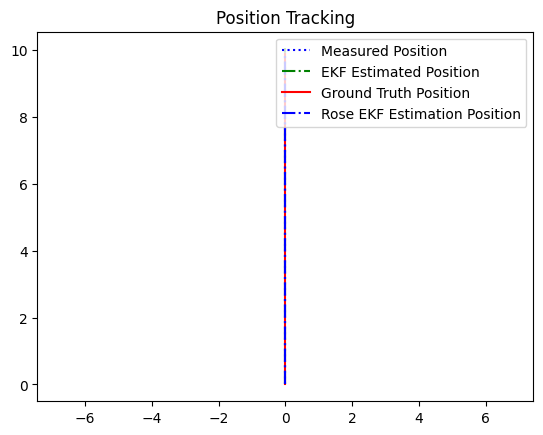

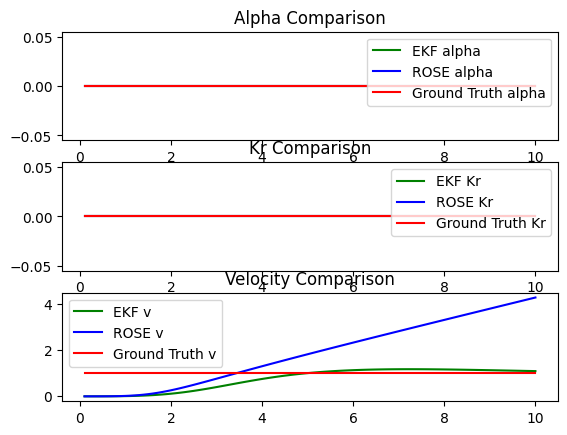

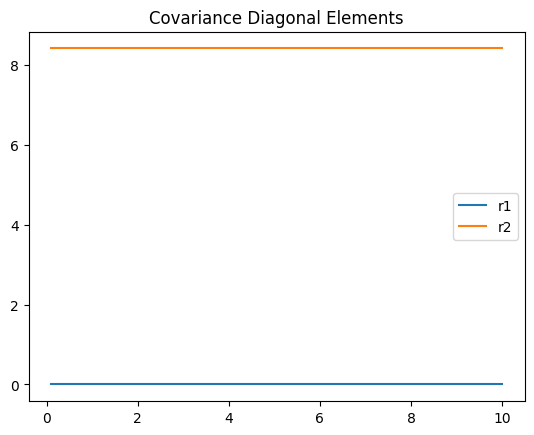

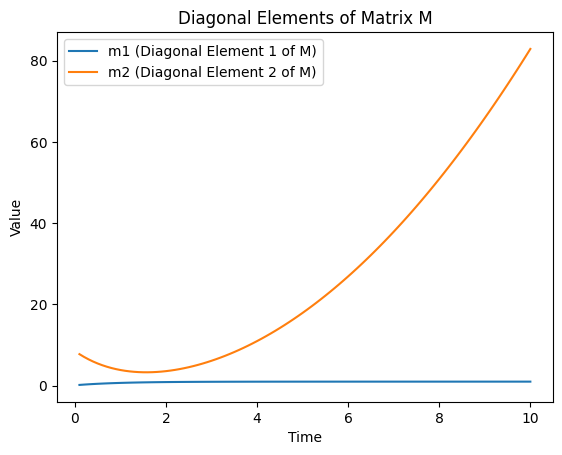

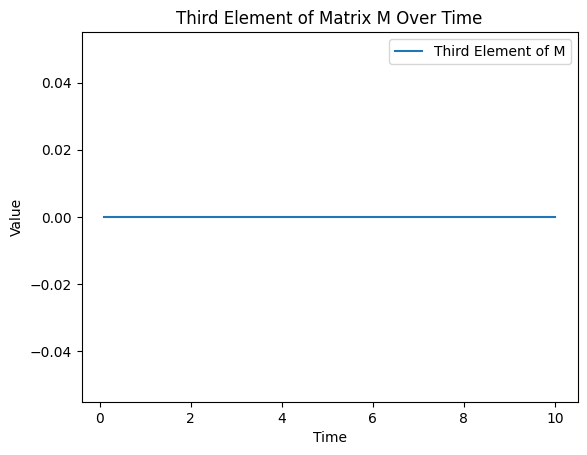

rms_xy KF: 0.009352696262797111 EKF: 0.9218103741006003 ROSE: 7.869397697440717
rms_alpha EKF: 0.0 ROSE: 0.0
rms_Kr EKF: 0.0 ROSE: 0.0
rms_v EKF: 0.5226630795521329 ROSE: 1.6336367392917566
Verbesserung EKF/ROSE: xy: 0.11713861842315977 alpha: nan Kr: nan v: 0.31993837245526635 Mittel: nan


/tmp/ipykernel_9467/1545284067.py:92: RuntimeWarning: invalid value encountered in scalar divide
  improvement = [rms_EKF_xy/rms_ROSE_xy, rms_EKF_a/rms_ROSE_a, rms_EKF_Kr/rms_ROSE_Kr, rms_EKF_v/rms_ROSE_v]


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming variables like y, xP, yP, GT, xR, yR, ROSE_x, ROSE_y, etc. are already defined as NumPy arrays or similar


# Plotting
plt.figure(1)
plt.clf()
plt.plot(y[0, :], y[1, :], 'b:', label='Measured Position')
plt.plot(xP, yP, 'g-.', label='EKF Estimated Position')
plt.plot(GT['x'], GT['y'], 'r-', label='Ground Truth Position')
plt.plot(xR, yR, 'b-.', label='Rose EKF Estimation Position')
plt.axis('equal')
plt.title('Position Tracking')
plt.legend()

plt.figure(2)
plt.clf()

plt.subplot(311)
plt.plot(t, alpha, 'g-', label='EKF alpha')
plt.plot(t, ROSE_alpha, 'b-', label='ROSE alpha')
plt.plot(t, GT['alpha'], 'r', label='Ground Truth alpha')
plt.title('Alpha Comparison')
plt.legend()

plt.subplot(312)
plt.plot(t, Kr, 'g-', label='EKF Kr')
plt.plot(t, ROSE_Kr, 'b-', label='ROSE Kr')
plt.plot(t, GT['Kr'], 'r', label='Ground Truth Kr')
plt.title('Kr Comparison')
plt.legend()

plt.subplot(313)
plt.plot(t, v, 'g-', label='EKF v')
plt.plot(t, ROSE_v, 'b-', label='ROSE v')
plt.plot(t, GT['v'], 'r', label='Ground Truth v')
plt.title('Velocity Comparison')
plt.legend()

plt.figure(3)
plt.clf()
plt.plot(t, r1, label='r1')
plt.plot(t, r2, label='r2')
plt.title('Covariance Diagonal Elements')
plt.legend()

# Plotting the diagonal elements of M
plt.figure(4)
plt.plot(t, m1, label='m1 (Diagonal Element 1 of M)')
plt.plot(t, m2, label='m2 (Diagonal Element 2 of M)')
plt.title('Diagonal Elements of Matrix M')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting the third element of M
plt.figure(5)
plt.plot(t, m3, label='Third Element of M')
plt.title('Third Element of Matrix M Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# RMS Calculations
rms_KF_xy = np.sqrt(np.mean((xR - GT['x'])**2 + (yR - GT['y'])**2))
rms_EKF_xy = np.sqrt(np.mean((xP - GT['x'])**2 + (yP - GT['y'])**2))
rms_ROSE_xy = np.sqrt(np.mean((ROSE_x - GT['x'])**2 + (ROSE_y - GT['y'])**2))

print(f'rms_xy KF: {rms_KF_xy} EKF: {rms_EKF_xy} ROSE: {rms_ROSE_xy}')

rms_EKF_a = np.sqrt(np.mean((EKF_alpha - GT['alpha'])**2))
rms_ROSE_a = np.sqrt(np.mean((ROSE_alpha - GT['alpha'])**2))

print(f'rms_alpha EKF: {rms_EKF_a} ROSE: {rms_ROSE_a}')

rms_EKF_Kr = np.sqrt(np.mean((EKF_Kr - GT['Kr'])**2))
rms_ROSE_Kr = np.sqrt(np.mean((ROSE_Kr - GT['Kr'])**2))

print(f'rms_Kr EKF: {rms_EKF_Kr} ROSE: {rms_ROSE_Kr}')

rms_EKF_v = np.sqrt(np.mean((EKF_v - GT['v'])**2))
rms_ROSE_v = np.sqrt(np.mean((ROSE_v - GT['v'])**2))

print(f'rms_v EKF: {rms_EKF_v} ROSE: {rms_ROSE_v}')

improvement = [rms_EKF_xy/rms_ROSE_xy, rms_EKF_a/rms_ROSE_a, rms_EKF_Kr/rms_ROSE_Kr, rms_EKF_v/rms_ROSE_v]
print(f'Verbesserung EKF/ROSE: xy: {improvement[0]} alpha: {improvement[1]} Kr: {improvement[2]} v: {improvement[3]} Mittel: {np.mean(improvement)}')

# Saving to a file
data = {
    'time': time,
    'Pos_x': Pos_x,
    'Pos_y': Pos_y,
    'GT_x': GT_x,
    'GT_y': GT_y,
    'GT_alpha': GT_alpha,
    'GT_Kr': GT_Kr,
    'GT_v': GT_v,
    'ROSE_x': ROSE_x,
    'ROSE_y': ROSE_y,
    'ROSE_alpha': ROSE_alpha,
    'ROSE_Kr': ROSE_Kr,
    'ROSE_v': ROSE_v,
    'EKF_x': EKF_x,
    'EKF_y': EKF_y,
    'EKF_alpha': EKF_alpha,
    'EKF_Kr': EKF_Kr,
    'EKF_v': EKF_v
}

df_to_save = pd.DataFrame(data)
df_to_save.to_csv('EKF_Rose_data2.csv', sep=',', index=False)
